In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
kidney = pd.read_csv("../data/kidney_disease.csv")
kidney.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
kidney.columns

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [4]:
kidney[['htn','dm','cad','pe','ane']] = kidney[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
kidney[['rbc','pc']] = kidney[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
kidney[['pcc','ba']] = kidney[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
kidney[['appet']] = kidney[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
kidney['classification'] = kidney['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
kidney.rename(columns={'classification':'class'},inplace=True)

kidney['pe'] = kidney['pe'].replace(to_replace='good',value=0) 
kidney['appet'] = kidney['appet'].replace(to_replace='no',value=0)
kidney['cad'] = kidney['cad'].replace(to_replace='\tno',value=0)
kidney['dm'] = kidney['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
kidney.drop('id',axis=1,inplace=True)

In [5]:
kidney.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44,7800,5.2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38,6000,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31,7500,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32,6700,3.9,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35,7300,4.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [6]:
#кол-во NAN в каждой колонке
len(kidney)-kidney.count()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       70
wc       105
rc       130
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [7]:
#показывает кол-во пропусков в каждой колонке
kidney.isnull().sum(axis = 1)

0      3
1      5
2      3
3      0
4      2
      ..
395    0
396    0
397    0
398    0
399    0
Length: 400, dtype: int64

<AxesSubplot:>

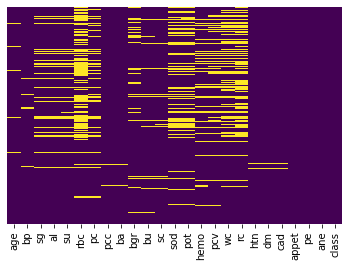

In [8]:
#Визуализация пустых мест
sns.heatmap(kidney.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
# Убираем пустые места
kidney2 = kidney.dropna()
kidney2.shape

(158, 25)

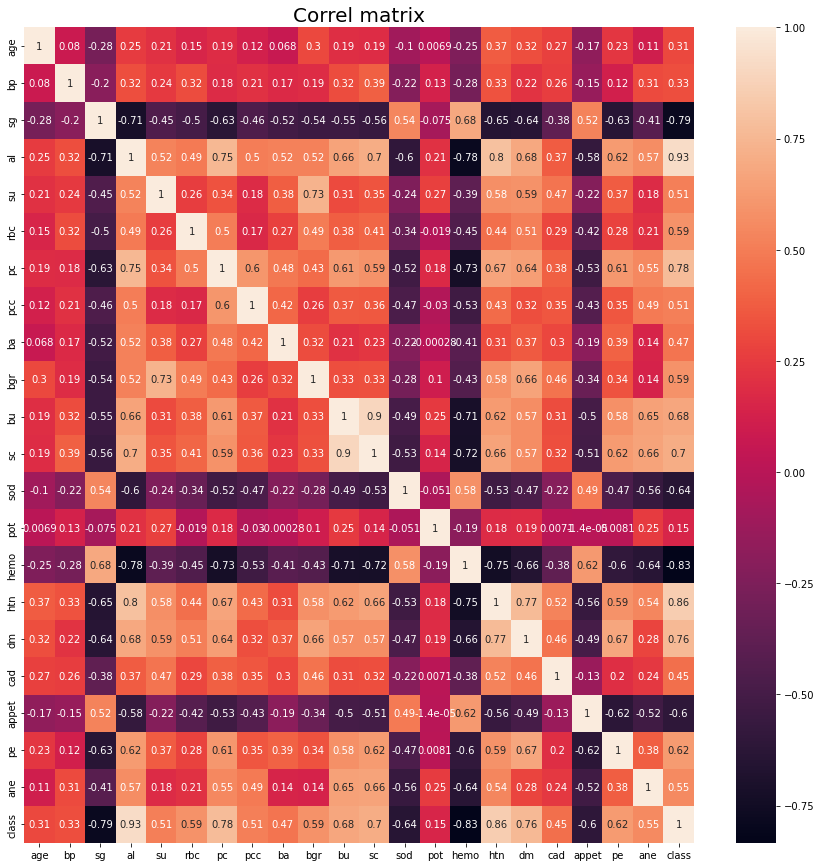

In [10]:
plt.figure(figsize=(15,15))
sns.heatmap(kidney2.corr(), annot=True) 
plt.title("Correl matrix", fontsize=20)
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


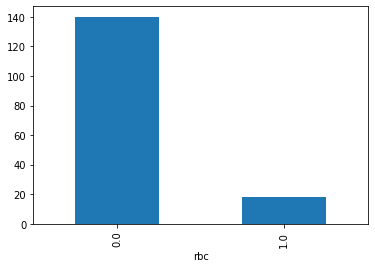

In [11]:
# считаем нормальное и не нормальное кол-во эритроцитов
print(kidney2.groupby('rbc').rbc.count().plot(kind="bar"))

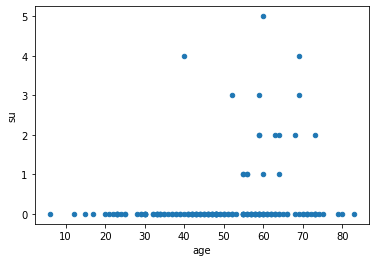

In [12]:
#Показывает уровень сахара и возраст пациента
kidney2.plot(kind='scatter', x='age',y='su');
plt.show()

In [13]:
#Показывает макс давление у людей с сахарным диабетом
print(kidney2.groupby('class').bp.max())

class
0.0     80.0
1.0    110.0
Name: bp, dtype: float64


In [14]:
kidney = pd.read_csv("../data/kidney_disease.csv")

In [15]:
def catconversion(df1):
    df1[['htn','dm','cad','pe','ane']] = df1[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
    df1[['rbc','pc']] = df1[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
    df1[['pcc','ba']] = df1[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
    df1[['appet']] = df1[['appet']].replace(to_replace={'good':1,'poor':0,'no':np.nan})
    df1['pe'] = df1['pe'].replace(to_replace='good',value=0) # Not having pedal edema is good
    df1['appet'] = df1['appet'].replace(to_replace='no',value=0)
    df1['cad'] = df1['cad'].replace(to_replace='\tno',value=0)
   
kidney['dm'] = kidney['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})
kidney['classification'] = kidney['classification'].replace(to_replace={'ckd':1.0,'ckd\t':1.0,'notckd':0.0,'no':0.0})
kidney.rename(columns={'classification':'class'},inplace=True)

catconversion(kidney)

<AxesSubplot:>

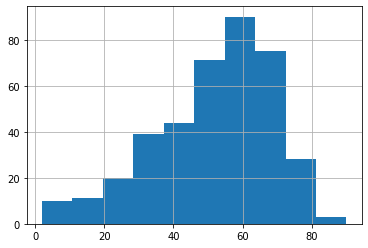

In [16]:
kidney["age"].hist()

In [17]:
mistyped=['Packed Cell Volume','White Blood Cells (cells/cmm)','Red Blood Cells (millions/cmm)']
numeric=[]
for i in kidney.columns:
    if kidney[i].dtype=='float64':
        numeric.append(i)
numeric=numeric+mistyped

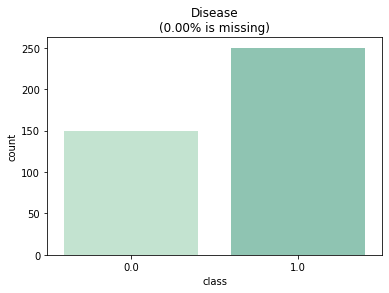

In [18]:
miss_perc="%.2f"%(100*(1-(kidney['class'].dropna().shape[0])/kidney.shape[0]))
    
label="Disease\n(missing:\n{}%)".format(miss_perc)
fig=sns.countplot(x=kidney['class'],label=label, palette=sns.cubehelix_palette(rot=-.35,light=0.85,hue=1))
plt.title("Disease\n({}% is missing)".format(miss_perc))
plt.show()

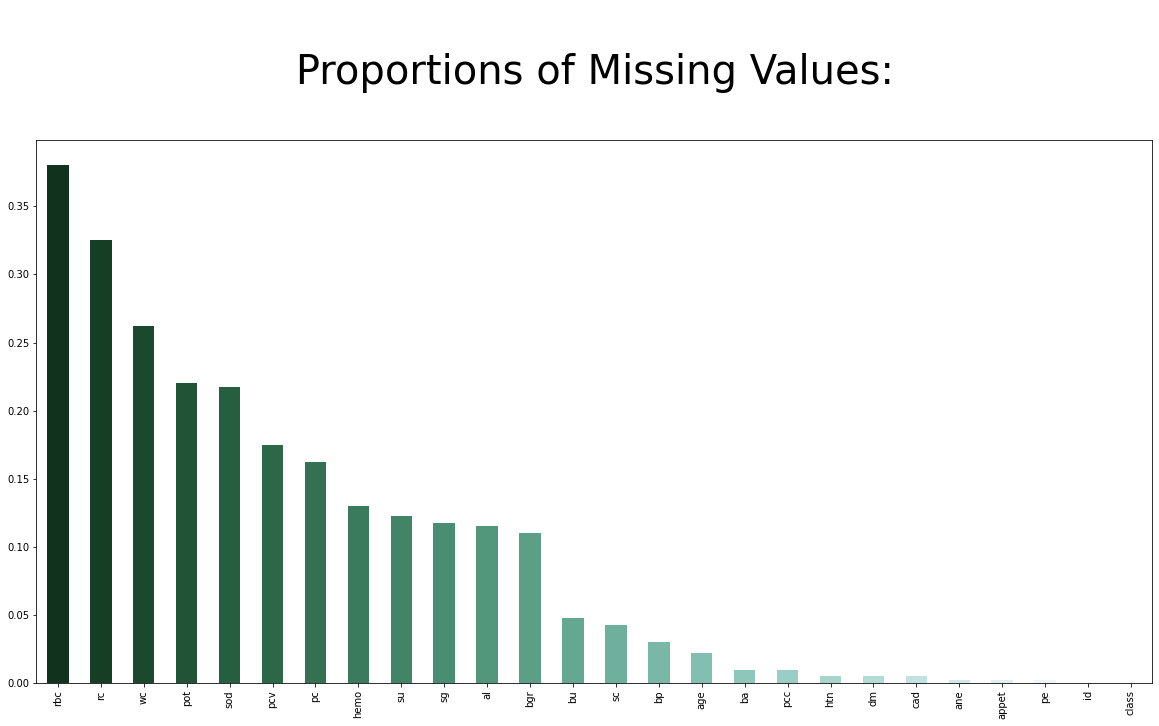

In [19]:
d=((kidney.isnull().sum()/kidney.shape[0])).sort_values(ascending=False)
d.plot(kind='bar',
       color=sns.cubehelix_palette(start=2,
                                    rot=0.15,
                                    dark=0.15,
                                    light=0.95,
                                    reverse=True,
                                    n_colors=24),
        figsize=(20,10))
plt.title("\nProportions of Missing Values:\n",fontsize=40)
plt.show()

In [20]:
onehotdata=pd.get_dummies(kidney,drop_first=True,prefix_sep=': ')
onehotdata.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,rc: 5.7,rc: 5.8,rc: 5.9,rc: 6.0,rc: 6.1,rc: 6.2,rc: 6.3,rc: 6.4,rc: 6.5,rc: 8.0
0,0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
